In [4]:
import numpy as np
import pandas as pd

INPUT_CSV = "ncaabb_teamStats.csv"

# columns in CSV that hold runs scored and runs allowed
RS_COL = "R (Batting)"    # runs scored
RA_COL = "R (Pitching)"   # runs allowed
WPCT_COL = "WPCT"         # actual win percentage in CSV

# grid search range for exponent
GRID_MIN, GRID_MAX, GRID_STEP = 0.5, 3.5, 0.01

# metric: RMSE
def rmse(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    if mask.sum() == 0:
        return np.nan
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

df = pd.read_csv(INPUT_CSV)

# ensure numeric
for c in [RS_COL, RA_COL, WPCT_COL]:
    if c not in df.columns:
        raise KeyError(f"Column {c} not found in CSV")
    df[c] = pd.to_numeric(df[c], errors="coerce")

# remove rows with missing RS/RA/WPCT
mask = ~df[RS_COL].isna() & ~df[RA_COL].isna() & ~df[WPCT_COL].isna()
df_clean = df[mask].copy()
# Filter so it's only 2021-2025, matching player_stat years
if "year" in df_clean.columns:
    df_clean = df_clean[(df_clean["year"] >= 2021) & (df_clean["year"] <= 2025)]

print(f"Using {len(df_clean)} rows for fitting (non-missing RS/RA/WPCT).")

# convert to numpy arrays
RS = df_clean[RS_COL].to_numpy(dtype=float)
RA = df_clean[RA_COL].to_numpy(dtype=float)
WPCT = df_clean[WPCT_COL].to_numpy(dtype=float)

# Check which years remain after cleaning
print(df_clean["year"].unique())

# Safety: avoid zero runs (if both zero, skip those rows)
valid = (RS + RA) > 0
RS = RS[valid]; RA = RA[valid]; WPCT = WPCT[valid]
print(f"{len(RS)} rows after removing zero total-run rows.")

# Grid search
grid = np.arange(GRID_MIN, GRID_MAX + 1e-9, GRID_STEP)
best_x = None
best_rmse = np.inf
rmses = []

for x in grid:
    # compute predicted win% for exponent x
    with np.errstate(over='ignore', invalid='ignore'):
        RSx = np.power(RS, x)
        RAx = np.power(RA, x)
        pred = RSx / (RSx + RAx)
    cur_rmse = rmse(WPCT, pred)
    rmses.append(cur_rmse)
    if np.isfinite(cur_rmse) and cur_rmse < best_rmse:
        best_rmse = cur_rmse
        best_x = x

print(f"Grid search best exponent: {best_x:.2f} with RMSE = {best_rmse:.5f}")

# compare to MLB baseline 1.83
mlb_x = 1.83
RSx = np.power(RS, mlb_x); RAx = np.power(RA, mlb_x)
mlb_pred = RSx / (RSx + RAx)
mlb_rmse = rmse(WPCT, mlb_pred)
print(f"Baseline exponent {mlb_x} RMSE = {mlb_rmse:.5f}")
print(f"Improvement % in RMSE: {((mlb_rmse - best_rmse) / mlb_rmse) * 100:.2f}")

# Compute per-year best exponent
compute_per_year = True
per_year_results = {}
if compute_per_year and "year" in df_clean.columns:
    for year, group in df_clean.groupby("year"):
        RSy = group[RS_COL].to_numpy(dtype=float)
        RAy = group[RA_COL].to_numpy(dtype=float)
        WPCTy = group[WPCT_COL].to_numpy(dtype=float)
        valid = (RSy + RAy) > 0
        RSy = RSy[valid]; RAy = RAy[valid]; WPCTy = WPCTy[valid]
        if len(RSy) < 10:  # skip tiny years
            continue
        
        # Find best exponent
        best_x_y = None
        best_rmse_y = np.inf
        for x in grid:
            RSx = np.power(RSy, x)
            RAx = np.power(RAy, x)
            pred = RSx / (RSx + RAx)
            cur_rmse = rmse(WPCTy, pred)
            if np.isfinite(cur_rmse) and cur_rmse < best_rmse_y:
                best_rmse_y = cur_rmse
                best_x_y = x
        
        # Calculate MLB 1.83 RMSE
        RSx_mlb = np.power(RSy, 1.83)
        RAx_mlb = np.power(RAy, 1.83)
        pred_mlb = RSx_mlb / (RSx_mlb + RAx_mlb)
        mlb_rmse_y = rmse(WPCTy, pred_mlb)
        
        # improvement %
        improvement_pct = ((mlb_rmse_y - best_rmse_y) / mlb_rmse_y) * 100
        
        # Results (best exponent, best RMSE, MLB RMSE, improvement %)
        per_year_results[year] = (best_x_y, best_rmse_y, mlb_rmse_y, improvement_pct)

    print("Per-year top exponents (sample):")
    for year in sorted(per_year_results.keys()):
        best_x_y, best_rmse_y, mlb_rmse_y, improvement_pct = per_year_results[year]
        print(
            int(year),
            (
                float(round(best_x_y, 3)),
                float(round(best_rmse_y, 4)),
                1.83,
                float(round(mlb_rmse_y, 4)),
                float(round(improvement_pct, 2))
            )
        )

Using 1468 rows for fitting (non-missing RS/RA/WPCT).
[2021 2022 2023 2024 2025]
1468 rows after removing zero total-run rows.
Grid search best exponent: 1.79 with RMSE = 0.04586
Baseline exponent 1.83 RMSE = 0.04594
Improvement % in RMSE: 0.16
Per-year top exponents (sample):
2021 (1.71, 0.0479, 1.83, 0.0486, 1.4)
2022 (1.77, 0.0443, 1.83, 0.0445, 0.41)
2023 (1.83, 0.0443, 1.83, 0.0443, -0.0)
2024 (1.85, 0.0446, 1.83, 0.0446, 0.02)
2025 (1.8, 0.0476, 1.83, 0.0476, 0.07)


In [2]:
import numpy as np
import pandas as pd

INPUT_CSV = "ncaabb_teamStats.csv"

# columns in CSV that hold runs scored and runs allowed
RS_COL = "R (Batting)"    # runs scored
RA_COL = "R (Pitching)"   # runs allowed
WPCT_COL = "WPCT"         # actual win percentage in CSV

# grid search range for exponent
GRID_MIN, GRID_MAX, GRID_STEP = 0.5, 3.5, 0.01

# metric: RMSE
def rmse(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    if mask.sum() == 0:
        return np.nan
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

df = pd.read_csv(INPUT_CSV)

# ensure numeric
for c in [RS_COL, RA_COL, WPCT_COL]:
    if c not in df.columns:
        raise KeyError(f"Column {c} not found in CSV")
    df[c] = pd.to_numeric(df[c], errors="coerce")

# remove rows with missing RS/RA/WPCT
mask = ~df[RS_COL].isna() & ~df[RA_COL].isna() & ~df[WPCT_COL].isna()
df_clean = df[mask].copy()
# Filter so it's only 2021-2025, matching player_stat years
if "year" in df_clean.columns:
    df_clean = df_clean[(df_clean["year"] >= 2021) & (df_clean["year"] <= 2025)]
    
print(f"Using {len(df_clean)} rows for fitting (non-missing RS/RA/WPCT).")

# convert to numpy arrays
RS = df_clean[RS_COL].to_numpy(dtype=float)
RA = df_clean[RA_COL].to_numpy(dtype=float)
WPCT = df_clean[WPCT_COL].to_numpy(dtype=float)

# Check which years remain after cleaning
print(df_clean["year"].unique())

# safety: avoid zero runs (if both zero, skip those rows)
valid = (RS + RA) > 0
RS = RS[valid]; RA = RA[valid]; WPCT = WPCT[valid]
print(f"{len(RS)} rows after removing zero total-run rows.")

# Grid search
grid = np.arange(GRID_MIN, GRID_MAX + 1e-9, GRID_STEP)
best_x = None
best_rmse = np.inf
rmses = []

for x in grid:
    # compute predicted win% for exponent x
    with np.errstate(over='ignore', invalid='ignore'):
        RSx = np.power(RS, x)
        RAx = np.power(RA, x)
        pred = RSx / (RSx + RAx)
    cur_rmse = rmse(WPCT, pred)
    rmses.append(cur_rmse)
    if np.isfinite(cur_rmse) and cur_rmse < best_rmse:
        best_rmse = cur_rmse
        best_x = x

print(f"Grid search best exponent: {best_x:.2f} with RMSE = {best_rmse:.5f}")

# compare to MLB baseline 1.83
mlb_x = 1.83
RSx = np.power(RS, mlb_x); RAx = np.power(RA, mlb_x)
mlb_pred = RSx / (RSx + RAx)
mlb_rmse = rmse(WPCT, mlb_pred)
print(f"Baseline exponent {mlb_x} RMSE = {mlb_rmse:.5f}")
print(f"Improvement % in RMSE: {((mlb_rmse - best_rmse) / mlb_rmse) * 100:.2f}")

# Compute per-year & per-conference best exponent
compute_per_conf = True
per_conf_results = {}

if compute_per_conf and "year" in df_clean.columns and "league" in df_clean.columns:
    for year, year_group in df_clean.groupby("year"):
        for conf, group in year_group.groupby("league"):
            RSy = group[RS_COL].to_numpy(dtype=float)
            RAy = group[RA_COL].to_numpy(dtype=float)
            WPCTy = group[WPCT_COL].to_numpy(dtype=float)
            
            # filter invalid games
            valid = (RSy + RAy) > 0
            RSy = RSy[valid]; RAy = RAy[valid]; WPCTy = WPCTy[valid]
            if len(RSy) < 3:  # skip tiny samples
                continue
            
            # Find best exponent
            best_x_c = None
            best_rmse_c = np.inf
            for x in grid:
                RSx = np.power(RSy, x)
                RAx = np.power(RAy, x)
                pred = RSx / (RSx + RAx)
                cur_rmse = rmse(WPCTy, pred)
                if np.isfinite(cur_rmse) and cur_rmse < best_rmse_c:
                    best_rmse_c = cur_rmse
                    best_x_c = x
            
            # MLB 1.83 RMSE
            RSx_mlb = np.power(RSy, 1.83)
            RAx_mlb = np.power(RAy, 1.83)
            pred_mlb = RSx_mlb / (RSx_mlb + RAx_mlb)
            mlb_rmse_c = rmse(WPCTy, pred_mlb)
            
            # improvement in RMSE
            improvement_pct = ((mlb_rmse_c - best_rmse_c) / mlb_rmse_c) * 100
            
            # results
            per_conf_results[(year, conf)] = (best_x_c, best_rmse_c, mlb_rmse_c, improvement_pct)

    print("Per-year per-conference top exponents:")
    for (year, conf), vals in sorted(per_conf_results.items()):
        best_x_c, best_rmse_c, mlb_rmse_c, improvement_pct = vals
        print(
            int(year),
            conf,
            (
                float(round(best_x_c, 3)),
                float(round(best_rmse_c, 4)),
                1.83,
                float(round(mlb_rmse_c, 4)),
                float(round(improvement_pct, 2))
            )
        )

# Find biggest difference from 1.83 across all (year, conference)
max_diff = -1
max_record = None

for (year, conf), (best_x_c, best_rmse_c, mlb_rmse_c, improvement_pct) in per_conf_results.items():
    diff = abs(best_x_c - 1.83)
    if diff > max_diff:
        max_diff = diff
        max_record = (year, conf, best_x_c, improvement_pct)

if max_record:
    year, conf, best_x_c, improvement_pct = max_record
    print(f"\nLargest deviation from 1.83: {year} in league {conf} with best_x = {best_x_c:.2f}, {improvement_pct:.2f}% improvement")

Using 1468 rows for fitting (non-missing RS/RA/WPCT).
[2021 2022 2023 2024 2025]
1468 rows after removing zero total-run rows.
Grid search best exponent: 1.79 with RMSE = 0.04586
Baseline exponent 1.83 RMSE = 0.04594
Improvement % in RMSE: 0.16
Per-year per-conference top exponents:
2021 ACC (1.78, 0.0404, 1.83, 0.0405, 0.12)
2021 ASUN (1.77, 0.0371, 1.83, 0.0373, 0.49)
2021 America East (1.31, 0.0396, 1.83, 0.0463, 14.44)
2021 Atlantic 10 (2.02, 0.0374, 1.83, 0.0389, 4.06)
2021 Big 12 (1.43, 0.0402, 1.83, 0.0513, 21.63)
2021 Big East (1.58, 0.0503, 1.83, 0.0532, 5.45)
2021 Big South (1.78, 0.0556, 1.83, 0.0557, 0.13)
2021 Big Ten (1.65, 0.0289, 1.83, 0.0313, 7.8)
2021 Big West (1.66, 0.0325, 1.83, 0.0354, 7.96)
2021 CAA (1.74, 0.026, 1.83, 0.0267, 2.55)
2021 CUSA (1.78, 0.059, 1.83, 0.0591, 0.18)
2021 Horizon (1.56, 0.0233, 1.83, 0.0329, 29.25)
2021 MAAC (1.67, 0.0718, 1.83, 0.0731, 1.77)
2021 MAC (1.68, 0.0447, 1.83, 0.0458, 2.29)
2021 MEAC (1.88, 0.0577, 1.83, 0.0578, 0.14)
2021 MVC

In [3]:
import numpy as np
import pandas as pd

RS_COL = "R (Batting)"
RA_COL = "R (Pitching)"
WPCT_COL = "WPCT"
GRID_MIN, GRID_MAX, GRID_STEP = 0.5, 3.5, 0.01

def rmse(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    if mask.sum() == 0:
        return np.nan
    return np.sqrt(np.mean((y_true[mask] - y_pred[mask]) ** 2))

df = pd.read_csv("ncaabb_teamStats.csv")

# numeric conversion + cleaning
for c in [RS_COL, RA_COL, WPCT_COL]:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df_clean = df.dropna(subset=[RS_COL, RA_COL, WPCT_COL])

# Filter so it's only 2021-2025, matching player_stat years
if "year" in df_clean.columns:
    df_clean = df_clean[(df_clean["year"] >= 2021) & (df_clean["year"] <= 2025)]

grid = np.arange(GRID_MIN, GRID_MAX + 1e-9, GRID_STEP)

# Best exponent per year
per_year_results = {}
for year, group in df_clean.groupby("year"):
    RSy, RAy, WPCTy = (
        group[RS_COL].to_numpy(float),
        group[RA_COL].to_numpy(float),
        group[WPCT_COL].to_numpy(float),
    )
    valid = (RSy + RAy) > 0
    RSy, RAy, WPCTy = RSy[valid], RAy[valid], WPCTy[valid]
    if len(RSy) < 3:
        continue
    
    best_x, best_rmse = None, np.inf
    for x in grid:
        pred = np.power(RSy, x) / (np.power(RSy, x) + np.power(RAy, x))
        cur_rmse = rmse(WPCTy, pred)
        if np.isfinite(cur_rmse) and cur_rmse < best_rmse:
            best_rmse, best_x = cur_rmse, x
    per_year_results[year] = best_x

# Best exponent per (year, conference)
per_conf_results = {}
for (year, conf), group in df_clean.groupby(["year", "league"]):
    RSy, RAy, WPCTy = (
        group[RS_COL].to_numpy(float),
        group[RA_COL].to_numpy(float),
        group[WPCT_COL].to_numpy(float),
    )
    valid = (RSy + RAy) > 0
    RSy, RAy, WPCTy = RSy[valid], RAy[valid], WPCTy[valid]
    if len(RSy) < 3:
        continue
    
    best_x, best_rmse = None, np.inf
    for x in grid:
        pred = np.power(RSy, x) / (np.power(RSy, x) + np.power(RAy, x))
        cur_rmse = rmse(WPCTy, pred)
        if np.isfinite(cur_rmse) and cur_rmse < best_rmse:
            best_rmse, best_x = cur_rmse, x
    per_conf_results[(year, conf)] = best_x

# Differences (conference – year)
diffs = {}
for (year, conf), conf_x in per_conf_results.items():
    if year in per_year_results:
        year_x = per_year_results[year]
        diff = round(conf_x - year_x, 3)
        diffs[(year, conf)] = (year_x, conf_x, diff)

# Print
print("\nConference vs Yearly Exponent Differences:")
for (year, conf), (year_x, conf_x, diff) in sorted(diffs.items()):
    print(
        f"In {year}, the best exponent was {year_x:.2f}. "
        f"For {conf}, it was {conf_x:.2f}, which is a difference of {diff:+.2f}."
    )

print("\nAverage differences by conference:")
conf_diffs_summary = {}
for (year, conf), (_, _, diff) in diffs.items():
    conf_diffs_summary.setdefault(conf, []).append(diff)

for conf, diff_list in conf_diffs_summary.items():
    avg_diff = np.mean(diff_list)
    std_diff = np.std(diff_list)
    print(f"{conf}: avg diff = {avg_diff:+.3f}, std = {std_diff:.3f}, n={len(diff_list)}")


Conference vs Yearly Exponent Differences:
In 2021, the best exponent was 1.71. For ACC, it was 1.78, which is a difference of +0.07.
In 2021, the best exponent was 1.71. For ASUN, it was 1.77, which is a difference of +0.06.
In 2021, the best exponent was 1.71. For America East, it was 1.31, which is a difference of -0.40.
In 2021, the best exponent was 1.71. For Atlantic 10, it was 2.02, which is a difference of +0.31.
In 2021, the best exponent was 1.71. For Big 12, it was 1.43, which is a difference of -0.28.
In 2021, the best exponent was 1.71. For Big East, it was 1.58, which is a difference of -0.13.
In 2021, the best exponent was 1.71. For Big South, it was 1.78, which is a difference of +0.07.
In 2021, the best exponent was 1.71. For Big Ten, it was 1.65, which is a difference of -0.06.
In 2021, the best exponent was 1.71. For Big West, it was 1.66, which is a difference of -0.05.
In 2021, the best exponent was 1.71. For CAA, it was 1.74, which is a difference of +0.03.
In 20

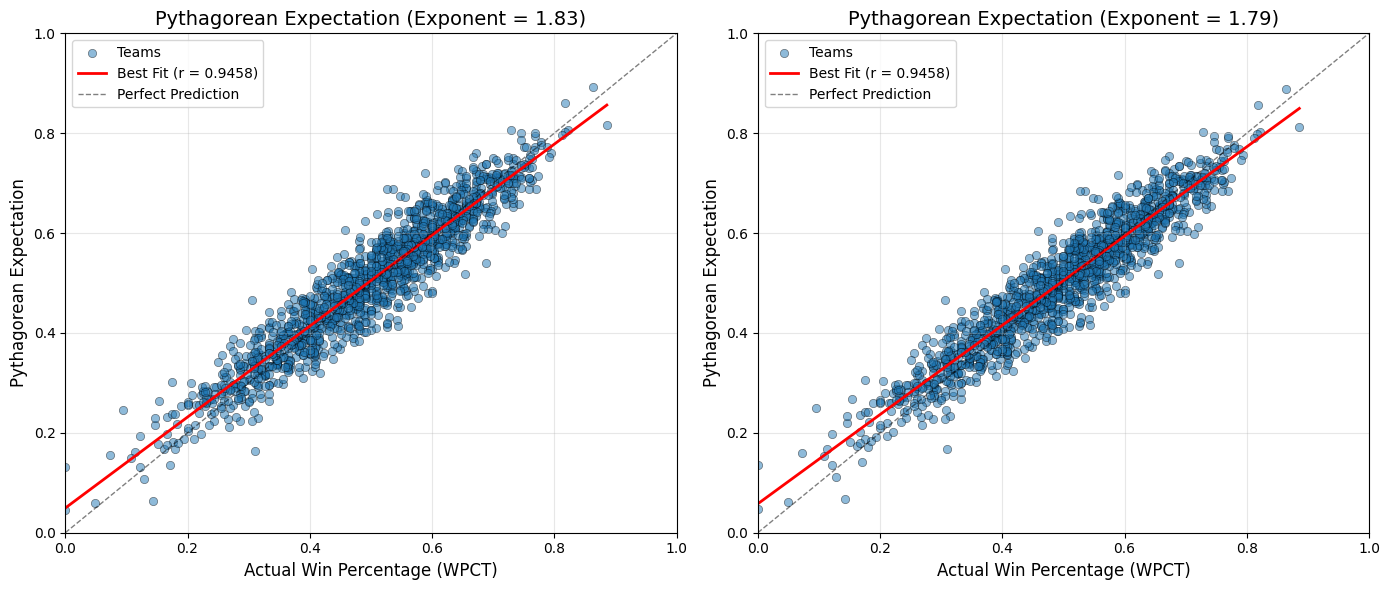


Summary Statistics

Exponent 1.83:
  Pearson's r = 0.9458
  Slope = 0.9108, Intercept = 0.0494

Exponent 1.79:
  Pearson's r = 0.9458
  Slope = 0.8936, Intercept = 0.0579


In [5]:
import matplotlib.pyplot as plt
from scipy import stats

# Calculate Pythagorean expectation for two exponents
exp_183 = 1.83
exp_179 = 1.79

# Pythagorean expectation: RS^exp / (RS^exp + RA^exp)
pyth_183 = np.power(RS, exp_183) / (np.power(RS, exp_183) + np.power(RA, exp_183))
pyth_179 = np.power(RS, exp_179) / (np.power(RS, exp_179) + np.power(RA, exp_179))

# Create figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Plot 1: Exponent 1.83 ---
ax1 = axes[0]
ax1.scatter(WPCT, pyth_183, alpha=0.5, edgecolors='k', linewidth=0.5, label='Teams')

# Line of best fit
slope_183, intercept_183, r_value_183, p_value_183, std_err_183 = stats.linregress(WPCT, pyth_183)
x_line = np.linspace(WPCT.min(), WPCT.max(), 100)
y_line_183 = slope_183 * x_line + intercept_183
ax1.plot(x_line, y_line_183, 'r-', linewidth=2, label=f'Best Fit (r = {r_value_183:.4f})')

# Perfect prediction line (y = x)
ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Perfect Prediction')

ax1.set_xlabel('Actual Win Percentage (WPCT)', fontsize=12)
ax1.set_ylabel('Pythagorean Expectation', fontsize=12)
ax1.set_title(f'Pythagorean Expectation (Exponent = {exp_183})', fontsize=14)
ax1.legend(loc='upper left')
ax1.set_xlim(0, 1)
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# --- Plot 2: Exponent 1.79 ---
ax2 = axes[1]
ax2.scatter(WPCT, pyth_179, alpha=0.5, edgecolors='k', linewidth=0.5, label='Teams')

# Line of best fit
slope_179, intercept_179, r_value_179, p_value_179, std_err_179 = stats.linregress(WPCT, pyth_179)
y_line_179 = slope_179 * x_line + intercept_179
ax2.plot(x_line, y_line_179, 'r-', linewidth=2, label=f'Best Fit (r = {r_value_179:.4f})')

# Perfect prediction line (y = x)
ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Perfect Prediction')

ax2.set_xlabel('Actual Win Percentage (WPCT)', fontsize=12)
ax2.set_ylabel('Pythagorean Expectation', fontsize=12)
ax2.set_title(f'Pythagorean Expectation (Exponent = {exp_179})', fontsize=14)
ax2.legend(loc='upper left')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n{'='*50}")
print("Summary Statistics")
print(f"{'='*50}")
print(f"\nExponent {exp_183}:")
print(f"  Pearson's r = {r_value_183:.4f}")
print(f"  Slope = {slope_183:.4f}, Intercept = {intercept_183:.4f}")

print(f"\nExponent {exp_179}:")
print(f"  Pearson's r = {r_value_179:.4f}")
print(f"  Slope = {slope_179:.4f}, Intercept = {intercept_179:.4f}")

League-specific Pythagorean Exponents vs MLB Baseline (1.83):
Patriot                  : Optimal exp = 1.45, r(opt) = 0.8970, r(1.83) = 0.8975, n = 30
Big 12                   : Optimal exp = 1.57, r(opt) = 0.8882, r(1.83) = 0.8891, n = 54
Southland                : Optimal exp = 1.59, r(opt) = 0.9255, r(1.83) = 0.9252, n = 50
Big Ten                  : Optimal exp = 1.63, r(opt) = 0.9291, r(1.83) = 0.9288, n = 69
SoCon                    : Optimal exp = 1.66, r(opt) = 0.9076, r(1.83) = 0.9072, n = 40
ACC                      : Optimal exp = 1.68, r(opt) = 0.9148, r(1.83) = 0.9153, n = 72
CAA                      : Optimal exp = 1.69, r(opt) = 0.9558, r(1.83) = 0.9556, n = 53
SEC                      : Optimal exp = 1.70, r(opt) = 0.9157, r(1.83) = 0.9158, n = 72
Mountain West            : Optimal exp = 1.72, r(opt) = 0.8685, r(1.83) = 0.8681, n = 36
SWAC                     : Optimal exp = 1.74, r(opt) = 0.9504, r(1.83) = 0.9498, n = 58
Big South                : Optimal exp = 1.77, r

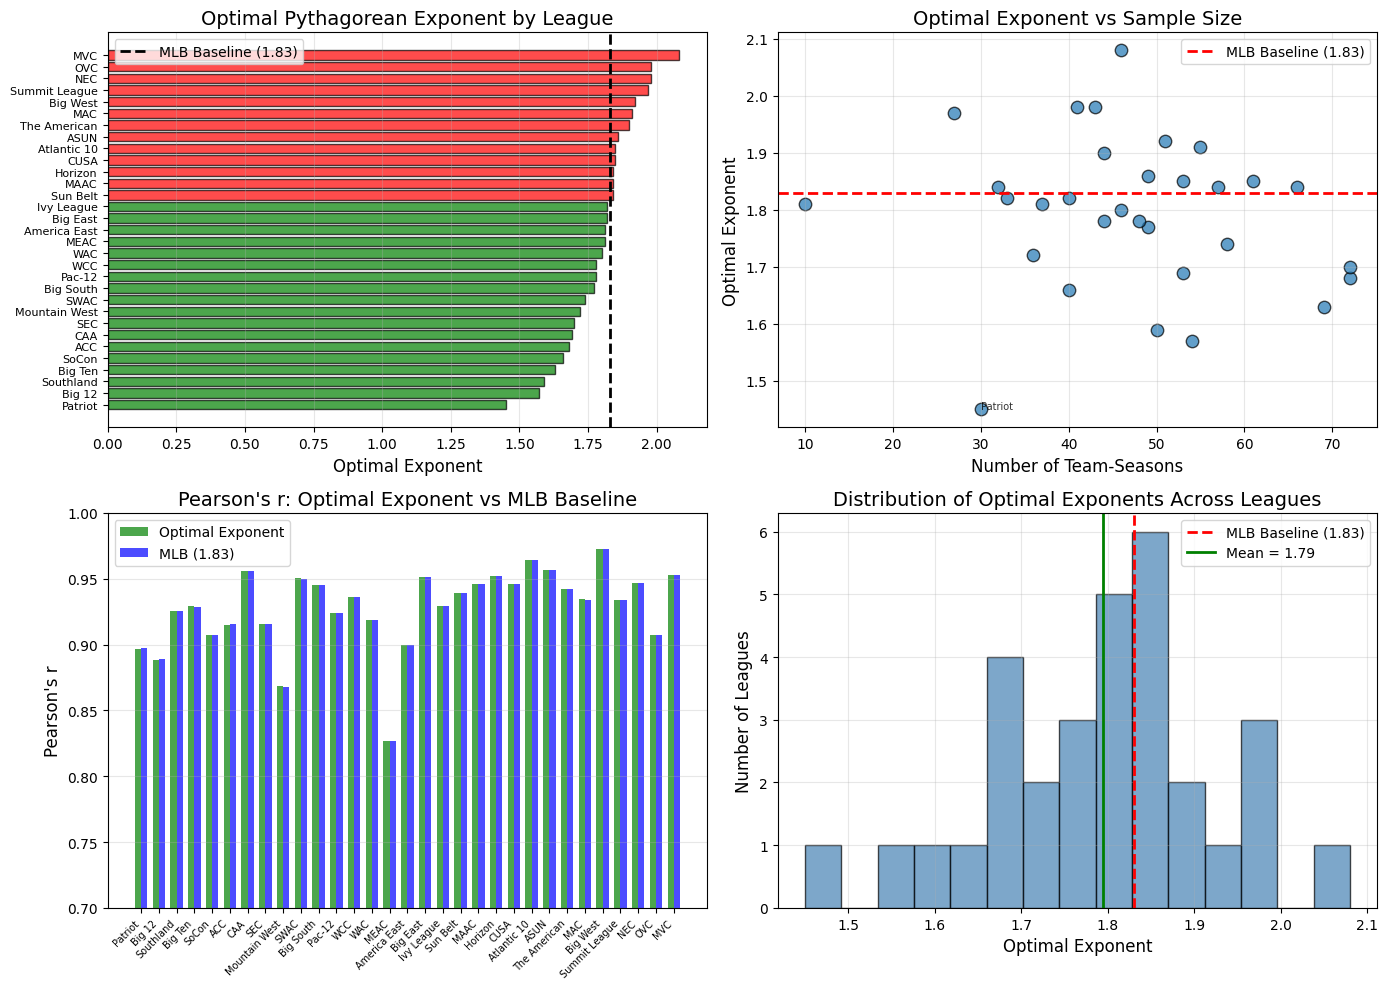


Summary Statistics
Mean optimal exponent across leagues: 1.795
Median optimal exponent: 1.810
Std dev: 0.134
Range: [1.45, 2.08]

Leagues with exp < 1.83: 18
Leagues with exp > 1.83: 13
Leagues with exp ≈ 1.83 (±0.1): 18


In [6]:
# Compare optimal exponents per league vs MLB baseline (1.83)

# First, compute best exponent per league (aggregated across all years)
league_results = {}

for league, group in df_clean.groupby("league"):
    RS_l = group[RS_COL].to_numpy(dtype=float)
    RA_l = group[RA_COL].to_numpy(dtype=float)
    WPCT_l = group[WPCT_COL].to_numpy(dtype=float)
    
    # Filter valid rows
    valid_l = (RS_l + RA_l) > 0
    RS_l, RA_l, WPCT_l = RS_l[valid_l], RA_l[valid_l], WPCT_l[valid_l]
    
    if len(RS_l) < 10:  # skip small samples
        continue
    
    # Find best exponent for this league
    best_x_l, best_rmse_l = None, np.inf
    for x in grid:
        pred_l = np.power(RS_l, x) / (np.power(RS_l, x) + np.power(RA_l, x))
        cur_rmse = rmse(WPCT_l, pred_l)
        if np.isfinite(cur_rmse) and cur_rmse < best_rmse_l:
            best_rmse_l, best_x_l = cur_rmse, x
    
    # Calculate MLB 1.83 RMSE and Pearson's r for this league
    pyth_mlb = np.power(RS_l, 1.83) / (np.power(RS_l, 1.83) + np.power(RA_l, 1.83))
    mlb_rmse_l = rmse(WPCT_l, pyth_mlb)
    r_mlb = stats.pearsonr(WPCT_l, pyth_mlb)[0]
    
    # Calculate Pearson's r for optimal exponent
    pyth_opt = np.power(RS_l, best_x_l) / (np.power(RS_l, best_x_l) + np.power(RA_l, best_x_l))
    r_opt = stats.pearsonr(WPCT_l, pyth_opt)[0]
    
    league_results[league] = {
        'best_exp': best_x_l,
        'best_rmse': best_rmse_l,
        'mlb_rmse': mlb_rmse_l,
        'r_mlb': r_mlb,
        'r_opt': r_opt,
        'n_teams': len(RS_l),
        'improvement_pct': ((mlb_rmse_l - best_rmse_l) / mlb_rmse_l) * 100
    }

# Create DataFrame for plotting
league_df = pd.DataFrame(league_results).T
league_df = league_df.sort_values('best_exp')
league_df.index.name = 'League'

print("League-specific Pythagorean Exponents vs MLB Baseline (1.83):")
print("="*80)
for league, row in league_df.iterrows():
    print(f"{league:25s}: Optimal exp = {row['best_exp']:.2f}, "
          f"r(opt) = {row['r_opt']:.4f}, r(1.83) = {row['r_mlb']:.4f}, "
          f"n = {int(row['n_teams'])}")

# --- Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Optimal exponents by league (bar chart)
ax1 = axes[0, 0]
colors = ['green' if x < 1.83 else 'red' if x > 1.83 else 'blue' for x in league_df['best_exp']]
bars = ax1.barh(range(len(league_df)), league_df['best_exp'], color=colors, alpha=0.7, edgecolor='k')
ax1.axvline(x=1.83, color='black', linestyle='--', linewidth=2, label='MLB Baseline (1.83)')
ax1.set_yticks(range(len(league_df)))
ax1.set_yticklabels(league_df.index, fontsize=8)
ax1.set_xlabel('Optimal Exponent', fontsize=12)
ax1.set_title('Optimal Pythagorean Exponent by League', fontsize=14)
ax1.legend()
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Exponent vs Sample Size (scatter)
ax2 = axes[0, 1]
ax2.scatter(league_df['n_teams'], league_df['best_exp'], s=80, alpha=0.7, edgecolors='k')
ax2.axhline(y=1.83, color='red', linestyle='--', linewidth=2, label='MLB Baseline (1.83)')
ax2.set_xlabel('Number of Team-Seasons', fontsize=12)
ax2.set_ylabel('Optimal Exponent', fontsize=12)
ax2.set_title('Optimal Exponent vs Sample Size', fontsize=14)
ax2.legend()
ax2.grid(alpha=0.3)

# Add league labels to a few outliers
for league, row in league_df.iterrows():
    if abs(row['best_exp'] - 1.83) > 0.3 or row['n_teams'] > 100:
        ax2.annotate(league, (row['n_teams'], row['best_exp']), fontsize=7, alpha=0.8)

# Plot 3: Pearson's r comparison (optimal vs 1.83)
ax3 = axes[1, 0]
x_pos = np.arange(len(league_df))
width = 0.35
ax3.bar(x_pos - width/2, league_df['r_opt'], width, label='Optimal Exponent', alpha=0.7, color='green')
ax3.bar(x_pos + width/2, league_df['r_mlb'], width, label='MLB (1.83)', alpha=0.7, color='blue')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(league_df.index, rotation=45, ha='right', fontsize=7)
ax3.set_ylabel("Pearson's r", fontsize=12)
ax3.set_title("Pearson's r: Optimal Exponent vs MLB Baseline", fontsize=14)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim(0.7, 1.0)

# Plot 4: Distribution of optimal exponents (histogram)
ax4 = axes[1, 1]
ax4.hist(league_df['best_exp'], bins=15, edgecolor='k', alpha=0.7, color='steelblue')
ax4.axvline(x=1.83, color='red', linestyle='--', linewidth=2, label='MLB Baseline (1.83)')
ax4.axvline(x=league_df['best_exp'].mean(), color='green', linestyle='-', linewidth=2, 
            label=f"Mean = {league_df['best_exp'].mean():.2f}")
ax4.set_xlabel('Optimal Exponent', fontsize=12)
ax4.set_ylabel('Number of Leagues', fontsize=12)
ax4.set_title('Distribution of Optimal Exponents Across Leagues', fontsize=14)
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n{'='*60}")
print("Summary Statistics")
print(f"{'='*60}")
print(f"Mean optimal exponent across leagues: {league_df['best_exp'].mean():.3f}")
print(f"Median optimal exponent: {league_df['best_exp'].median():.3f}")
print(f"Std dev: {league_df['best_exp'].std():.3f}")
print(f"Range: [{league_df['best_exp'].min():.2f}, {league_df['best_exp'].max():.2f}]")
print(f"\nLeagues with exp < 1.83: {(league_df['best_exp'] < 1.83).sum()}")
print(f"Leagues with exp > 1.83: {(league_df['best_exp'] > 1.83).sum()}")
print(f"Leagues with exp ≈ 1.83 (±0.1): {((league_df['best_exp'] >= 1.73) & (league_df['best_exp'] <= 1.93)).sum()}")

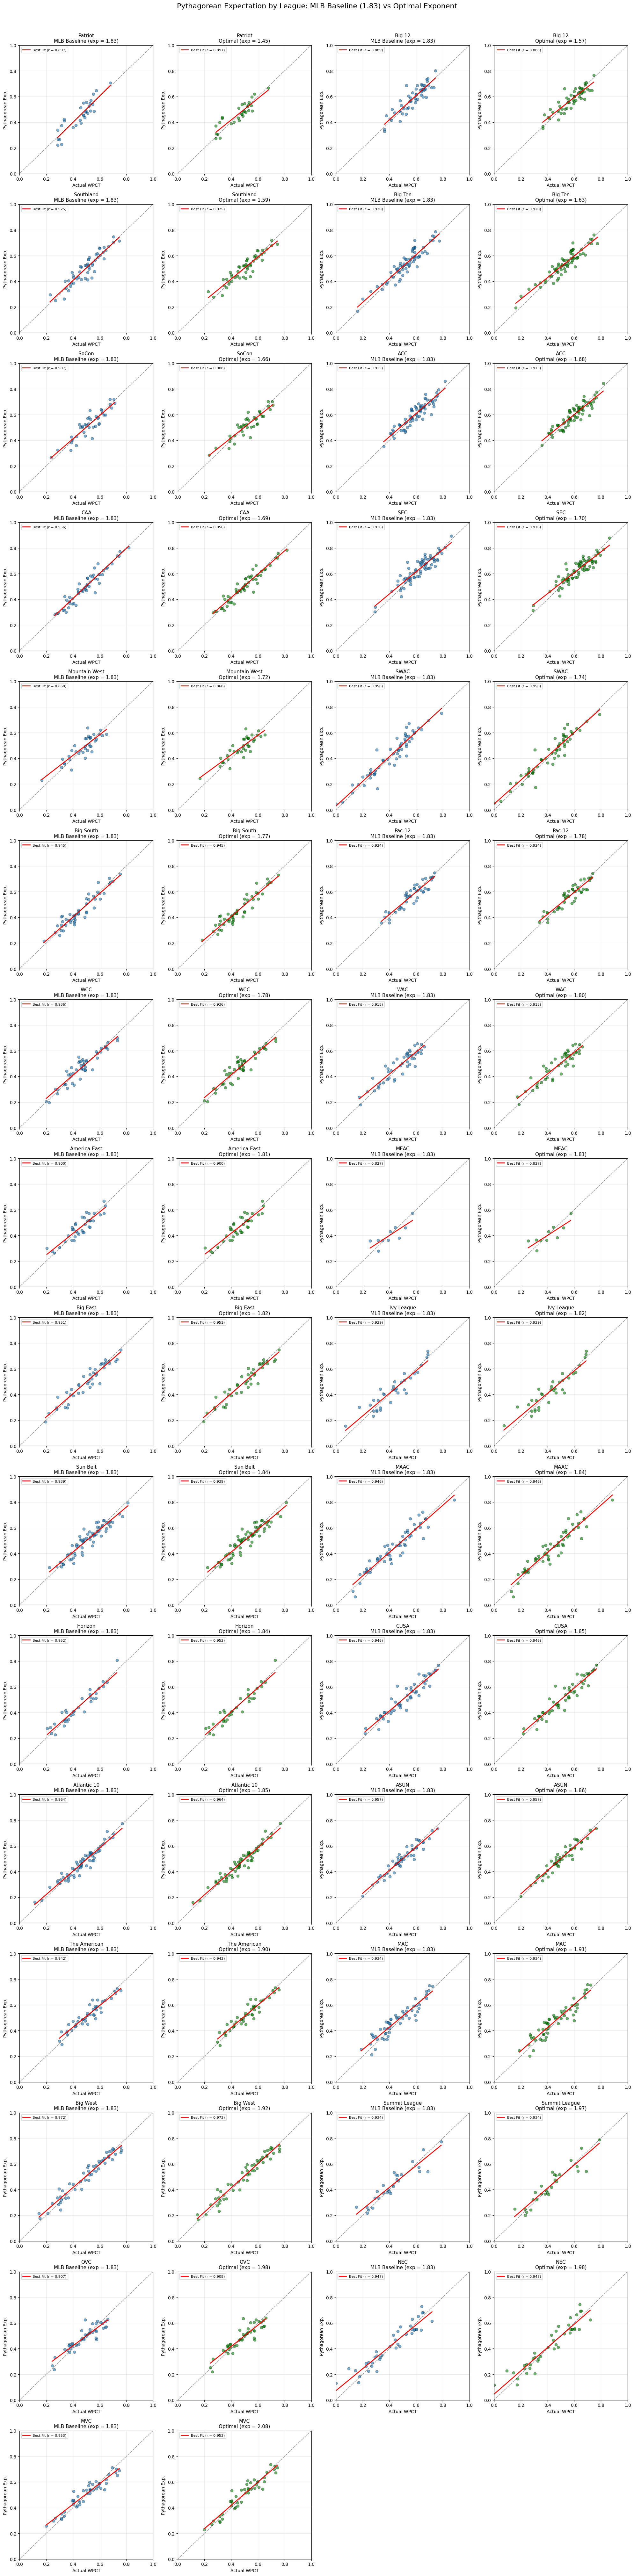


League Comparison Summary
League                Optimal Exp   r (1.83)    r (Opt)       Δr      n
--------------------------------------------------------------------------------
Patriot                      1.45     0.8975     0.8970  -0.0005     30
Big 12                       1.57     0.8891     0.8882  -0.0009     54
Southland                    1.59     0.9252     0.9255  +0.0003     50
Big Ten                      1.63     0.9288     0.9291  +0.0003     69
SoCon                        1.66     0.9072     0.9076  +0.0003     40
ACC                          1.68     0.9153     0.9148  -0.0005     72
CAA                          1.69     0.9556     0.9558  +0.0003     53
SEC                          1.70     0.9158     0.9157  -0.0002     72
Mountain West                1.72     0.8681     0.8685  +0.0004     36
SWAC                         1.74     0.9498     0.9504  +0.0006     58
Big South                    1.77     0.9450     0.9451  +0.0001     49
Pac-12                      

In [7]:
# Individual league plots: Optimal exponent vs MLB 1.83 baseline

# Get list of leagues sorted by best exponent
leagues_sorted = league_df.sort_values('best_exp').index.tolist()

# Calculate number of rows needed (2 plots per league, 4 columns)
n_leagues = len(leagues_sorted)
n_cols = 4  # 2 leagues per row (each league gets 2 subplots)
n_rows = (n_leagues + 1) // 2  # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()

plot_idx = 0
for league in leagues_sorted:
    # Get league data
    group = df_clean[df_clean['league'] == league]
    RS_l = group[RS_COL].to_numpy(dtype=float)
    RA_l = group[RA_COL].to_numpy(dtype=float)
    WPCT_l = group[WPCT_COL].to_numpy(dtype=float)
    
    # Filter valid rows
    valid_l = (RS_l + RA_l) > 0
    RS_l, RA_l, WPCT_l = RS_l[valid_l], RA_l[valid_l], WPCT_l[valid_l]
    
    # Get optimal exponent for this league
    opt_exp = league_df.loc[league, 'best_exp']
    
    # Calculate Pythagorean expectations
    pyth_opt = np.power(RS_l, opt_exp) / (np.power(RS_l, opt_exp) + np.power(RA_l, opt_exp))
    pyth_183 = np.power(RS_l, 1.83) / (np.power(RS_l, 1.83) + np.power(RA_l, 1.83))
    
    # --- Plot 1: MLB Baseline (1.83) ---
    ax1 = axes[plot_idx]
    ax1.scatter(WPCT_l, pyth_183, alpha=0.6, edgecolors='k', linewidth=0.5, s=40)
    
    # Line of best fit
    slope_mlb, intercept_mlb, r_mlb, _, _ = stats.linregress(WPCT_l, pyth_183)
    x_line = np.linspace(WPCT_l.min(), WPCT_l.max(), 100)
    y_line_mlb = slope_mlb * x_line + intercept_mlb
    ax1.plot(x_line, y_line_mlb, 'r-', linewidth=2, label=f'Best Fit (r = {r_mlb:.3f})')
    
    # Perfect prediction line
    ax1.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)
    
    ax1.set_xlabel('Actual WPCT', fontsize=10)
    ax1.set_ylabel('Pythagorean Exp.', fontsize=10)
    ax1.set_title(f'{league}\nMLB Baseline (exp = 1.83)', fontsize=11)
    ax1.legend(loc='upper left', fontsize=8)
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    ax1.grid(True, alpha=0.3)
    
    # --- Plot 2: Optimal Exponent ---
    ax2 = axes[plot_idx + 1]
    ax2.scatter(WPCT_l, pyth_opt, alpha=0.6, edgecolors='k', linewidth=0.5, s=40, color='green')
    
    # Line of best fit
    slope_opt, intercept_opt, r_opt, _, _ = stats.linregress(WPCT_l, pyth_opt)
    y_line_opt = slope_opt * x_line + intercept_opt
    ax2.plot(x_line, y_line_opt, 'r-', linewidth=2, label=f'Best Fit (r = {r_opt:.3f})')
    
    # Perfect prediction line
    ax2.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5)
    
    ax2.set_xlabel('Actual WPCT', fontsize=10)
    ax2.set_ylabel('Pythagorean Exp.', fontsize=10)
    ax2.set_title(f'{league}\nOptimal (exp = {opt_exp:.2f})', fontsize=11)
    ax2.legend(loc='upper left', fontsize=8)
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.grid(True, alpha=0.3)
    
    plot_idx += 2

# Hide any unused subplots
for i in range(plot_idx, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.suptitle('Pythagorean Expectation by League: MLB Baseline (1.83) vs Optimal Exponent', 
             fontsize=16, y=1.01)
plt.show()

# Print summary table
print(f"\n{'='*80}")
print("League Comparison Summary")
print(f"{'='*80}")
print(f"{'League':<20} {'Optimal Exp':>12} {'r (1.83)':>10} {'r (Opt)':>10} {'Δr':>8} {'n':>6}")
print("-"*80)
for league in leagues_sorted:
    row = league_df.loc[league]
    delta_r = row['r_opt'] - row['r_mlb']
    print(f"{league:<20} {row['best_exp']:>12.2f} {row['r_mlb']:>10.4f} {row['r_opt']:>10.4f} {delta_r:>+8.4f} {int(row['n_teams']):>6}")